In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# SLAM

The goal of this problem is the implementation and testing of a simultaneous localization and mapping
(SLAM) system for a robot equipped with a LIDAR. Assume the LIDAR provides range measurements
along 61 angles from −30◦
to 30◦ with a 1◦
step and centered with the robot forward axis.
The data slam.txt contains data from the robot while moving in a rectangular room. The first three
columns are the pose of the robot (x, y, .and θ – exact values), the next three columns are the measured variations of the robot pose, and the last 31 columns are the LIDAR measurements (assumed
instantaneous).

In [2]:
import pandas as pd
import numpy as np

def load_slam_data(filepath):
    """
    Load SLAM data from a text file into a structured pandas DataFrame.

    Parameters:
    filepath (str): Path to the data file

    Returns:
    pandas.DataFrame: DataFrame with columns for robot pose, measured variations, and LIDAR measurements
    """
    # Load the raw data
    data = pd.read_csv(filepath, delim_whitespace=True, header=None)

    # Define column names
    # First 3 columns: robot pose
    pose_cols = ['x', 'y', 'theta']

    # Next 3 columns: measured variations
    variation_cols = ['delta_x', 'delta_y', 'delta_theta']

    # Last 61 columns: LIDAR measurements (-30° to 30° with 1° step)
    angles = np.arange(-30, 31, 1)
    lidar_cols = [f'lidar_{angle}' for angle in angles]

    # Combine all column names
    all_cols = pose_cols + variation_cols + lidar_cols

    # Assign column names to DataFrame
    data.columns = all_cols

    return data

def print_data_summary(data):
    """
    Print a summary of the SLAM data.

    Parameters:
    data (pandas.DataFrame): The loaded SLAM data
    """
    print("SLAM Data Summary:")
    print(f"Number of timestamps: {len(data)}")
    print("\nRobot pose ranges:")
    for col in ['x', 'y', 'theta']:
        print(f"{col}: {data[col].min():.2f} to {data[col].max():.2f}")

    print("\nMeasured variations ranges:")
    for col in ['delta_x', 'delta_y', 'delta_theta']:
        print(f"{col}: {data[col].min():.2f} to {data[col].max():.2f}")

    print("\nLIDAR measurement ranges:")
    lidar_cols = [col for col in data.columns if 'lidar_' in col]
    lidar_min = data[lidar_cols].min().min()
    lidar_max = data[lidar_cols].max().max()
    print(f"All LIDAR measurements: {lidar_min:.2f} to {lidar_max:.2f}")

In [3]:
# Load the data
slam_data = load_slam_data('data_slam.txt')
# remove first line because data is corrupted
slam_data = slam_data[1:]

# Print summary of the data
print_data_summary(slam_data)

# Access specific components
print("\nFirst few rows of robot pose:")
print(slam_data[['x', 'y', 'theta']].head())
print("\nPandas dataframe")
print(slam_data.columns)

SLAM Data Summary:
Number of timestamps: 71

Robot pose ranges:
x: 2.00 to 6.00
y: 4.00 to 8.00
theta: 1.75 to 13.96

Measured variations ranges:
delta_x: -0.34 to 0.39
delta_y: -0.42 to 0.45
delta_theta: -0.02 to 0.38

LIDAR measurement ranges:
All LIDAR measurements: 2.50 to 13.36

First few rows of robot pose:
          x         y     theta
1  5.969615  6.347296  1.745329
2  5.879385  6.684040  1.919862
3  5.732051  7.000000  2.094395
4  5.532089  7.285575  2.268928
5  5.285575  7.532089  2.443461

Pandas dataframe
Index(['x', 'y', 'theta', 'delta_x', 'delta_y', 'delta_theta', 'lidar_-30',
       'lidar_-29', 'lidar_-28', 'lidar_-27', 'lidar_-26', 'lidar_-25',
       'lidar_-24', 'lidar_-23', 'lidar_-22', 'lidar_-21', 'lidar_-20',
       'lidar_-19', 'lidar_-18', 'lidar_-17', 'lidar_-16', 'lidar_-15',
       'lidar_-14', 'lidar_-13', 'lidar_-12', 'lidar_-11', 'lidar_-10',
       'lidar_-9', 'lidar_-8', 'lidar_-7', 'lidar_-6', 'lidar_-5', 'lidar_-4',
       'lidar_-3', 'lidar_-2', '

<ipython-input-2-509bd2f53cde>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, delim_whitespace=True, header=None)


# Task1
Implement an algorithm that processes each LIDAR measurement (61 angles) and detects corners. Process all the measurements and locate the detected corners with respect to the robot position. Using the
exact location of the robot build a map with the four corners fo the room.

## Point Cloud Visualization

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def polar_to_cartesian(ranges, angles):
    """Convert polar coordinates to cartesian coordinates."""
    x = ranges * np.cos(angles)
    y = ranges * np.sin(angles)
    return x, y

def transform_to_global(local_x, local_y, robot_x, robot_y, robot_theta):
    """Transform points from robot's local frame to global frame."""
    # Create rotation matrix
    R = np.array([[np.cos(robot_theta), -np.sin(robot_theta)],
                  [np.sin(robot_theta), np.cos(robot_theta)]])

    # Stack points for vectorized transformation
    local_points = np.vstack((local_x, local_y))

    # Apply rotation and translation
    global_points = R @ local_points
    global_x = global_points[0, :] + robot_x
    global_y = global_points[1, :] + robot_y

    return global_x, global_y

def plot_lidar_scan(slam_data, scan_index, show_robot=True):
    """
    Plot a single LIDAR scan in global coordinates.

    Parameters:
    slam_data: DataFrame containing SLAM data
    scan_index: Index of the scan to plot
    show_robot: Whether to show robot position and orientation
    """
    # Get robot pose
    robot_x = slam_data.iloc[scan_index]['x']
    robot_y = slam_data.iloc[scan_index]['y']
    robot_theta = slam_data.iloc[scan_index]['theta']

    # Get LIDAR measurements
    lidar_cols = [col for col in slam_data.columns if 'lidar_' in col]
    ranges = slam_data.iloc[scan_index][lidar_cols].values

    # Create angle array (-30° to 30° with 1° steps)
    angles = np.deg2rad(np.arange(-30, 31, 1))

    # Convert to cartesian coordinates (local frame)
    local_x, local_y = polar_to_cartesian(ranges, angles)

    # Transform to global frame
    global_x, global_y = transform_to_global(local_x, local_y, robot_x, robot_y, robot_theta)

    # Create plot
    plt.figure(figsize=(10, 10))
    plt.scatter(global_x, global_y, c='b', s=10, label='LIDAR points')

    if show_robot:
        # Plot robot position
        plt.scatter(robot_x, robot_y, c='r', s=100, label='Robot')

        # Plot robot orientation (a line showing the forward direction)
        orientation_length = 0.5
        plt.arrow(robot_x, robot_y,
                 orientation_length * np.cos(robot_theta),
                 orientation_length * np.sin(robot_theta),
                 head_width=0.1, head_length=0.1, fc='r', ec='r')

    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.title(f'LIDAR Scan at index {scan_index}')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.show()

def plot_multiple_scans(slam_data, indices, legend=False):
	"""Plot multiple LIDAR scans on the same plot."""
	plt.figure(figsize=(10, 10))

	for idx in indices:
		# Get robot pose
		robot_x = slam_data.iloc[idx]['x']
		robot_y = slam_data.iloc[idx]['y']
		robot_theta = slam_data.iloc[idx]['theta']

		# Get LIDAR measurements
		lidar_cols = [col for col in slam_data.columns if 'lidar_' in col]
		ranges = slam_data.iloc[idx][lidar_cols].values
		# Create angle array
		angles = np.deg2rad(np.arange(-30, 31, 1))

		# Convert to cartesian and transform to global frame
		local_x, local_y = polar_to_cartesian(ranges, angles)
		global_x, global_y = transform_to_global(local_x, local_y, robot_x, robot_y, robot_theta)

		# Plot points
		plt.scatter(global_x, global_y, s=10, alpha=0.5, label=f'Scan {idx}')

		# Plot robot position with index number
		plt.scatter(robot_x, robot_y, c='r', s=100)
		plt.annotate(str(idx), (robot_x, robot_y),
					xytext=(5, 5), textcoords='offset points',
					color='black', fontweight='bold')

		# Add orientation arrow
		orientation_length = 0.3
		plt.arrow(robot_x, robot_y,
					orientation_length * np.cos(robot_theta),
					orientation_length * np.sin(robot_theta),
					head_width=0.1, head_length=0.1, fc='r', ec='r')

	plt.axis('equal')
	plt.grid(True)
	if (legend):
		plt.legend()
	plt.title('Multiple LIDAR Scans')
	plt.xlabel('X (m)')
	plt.ylabel('Y (m)')
	#plt.show()

def plot_multiple_scans_with_estimation(slam_data, estimation, indices, legend=False):
	"""Plot multiple LIDAR scans on the same plot."""
	plt.figure(figsize=(10, 10))

	# add the estimated trajectory
	plt.plot(estimation[:, 0], estimation[:, 1], ".-", label='Estimated path', alpha=0.5)

	for idx in indices:
		# Get robot pose
		robot_x = estimation[idx, 0]
		robot_y = estimation[idx, 1]
		robot_theta = estimation[idx, 2]

		# Get LIDAR measurements
		lidar_cols = [col for col in slam_data.columns if 'lidar_' in col]
		ranges = slam_data.iloc[idx][lidar_cols].values

		# Create angle array
		angles = np.deg2rad(np.arange(-30, 31, 1))

		# Convert to cartesian and transform to global frame
		local_x, local_y = polar_to_cartesian(ranges, angles)
		global_x, global_y = transform_to_global(local_x, local_y, robot_x, robot_y, robot_theta)

		# Plot points
		plt.scatter(global_x, global_y, s=10, alpha=0.5, label=f'Scan {idx}')

		# Plot robot position with index number
		plt.scatter(robot_x, robot_y, c='r', s=100)
		plt.annotate(str(idx), (robot_x, robot_y),
					xytext=(5, 5), textcoords='offset points',
					color='black', fontweight='bold')

		# Add orientation arrow
		orientation_length = 0.3
		plt.arrow(robot_x, robot_y,
					orientation_length * np.cos(robot_theta),
					orientation_length * np.sin(robot_theta),
					head_width=0.1, head_length=0.1, fc='r', ec='r')

	plt.axis('equal')
	plt.grid(True)
	if (legend):
		plt.legend()
	plt.title('Multiple LIDAR Scans')
	plt.xlabel('X (m)')
	plt.ylabel('Y (m)')
	#plt.show()

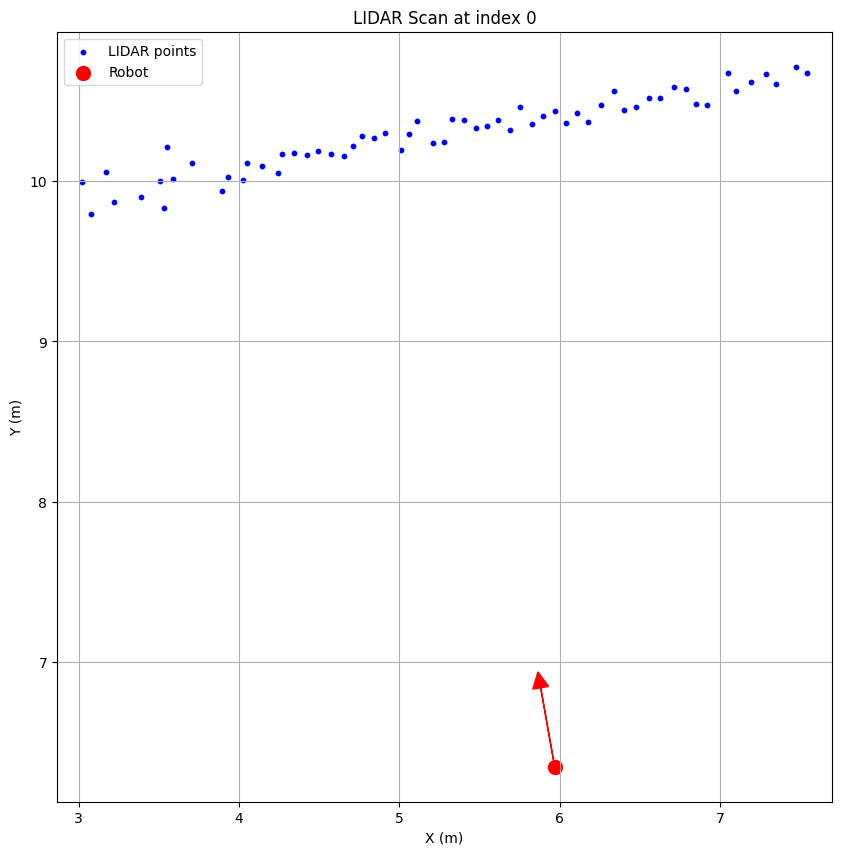

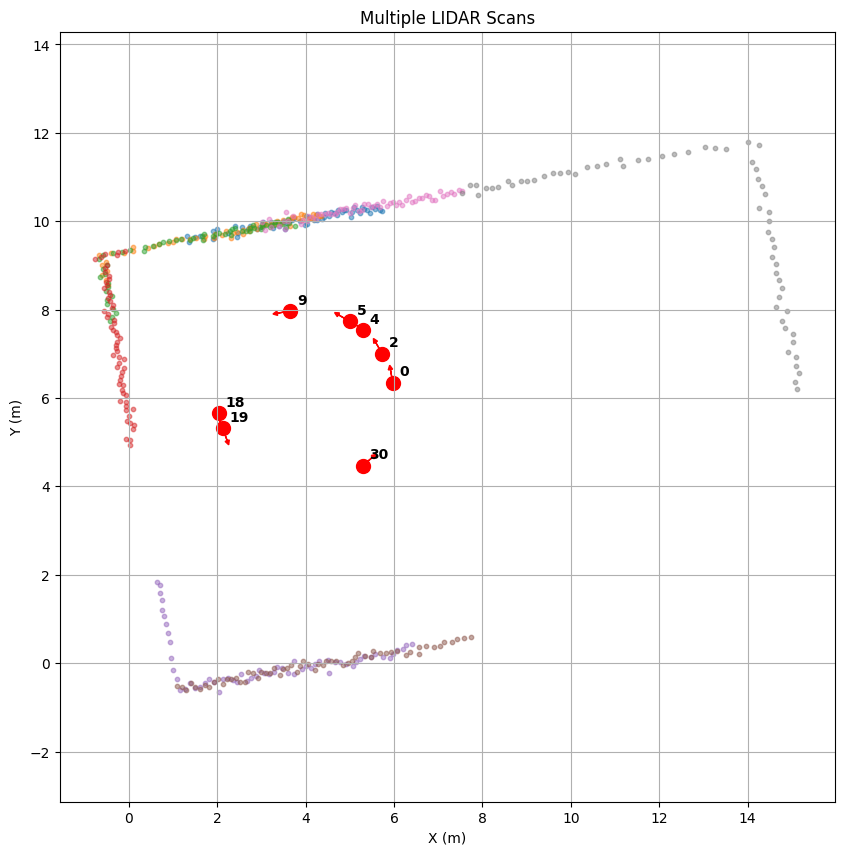

In [5]:
# Plot a single scan
plot_lidar_scan(slam_data, scan_index=0)

# Plot multiple scans to see how the room looks
plot_multiple_scans(slam_data, indices=[2, 4, 5, 9, 18, 19, 0, 30])
#plot_multiple_scans(slam_data, indices=[12])

## Corner detection

In [6]:
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks

def window_filter(ranges, window_size=3):
    """
    Apply a simple moving average window filter to LiDAR data

    Args:
        ranges (numpy.array): Array of range measurements
        window_size (int): Size of the averaging window (odd number)

    Returns:
        numpy.array: Filtered range measurements
    """
    if window_size % 2 == 0:
        window_size += 1  # Ensure window size is odd

    filtered = np.copy(ranges)
    half_window = window_size // 2

    for i in range(len(ranges)):
        # Calculate window boundaries
        start_idx = max(0, i - half_window)
        end_idx = min(len(ranges), i + half_window + 1)

        # Calculate mean of the window
        window_mean = np.mean(ranges[start_idx:end_idx])
        filtered[i] = window_mean

    return filtered

def corner_detector(angles, ranges):

	# find maximums
	peaks, _ = find_peaks(ranges, prominence=0.1, distance=5)

	results = []
	flag = False
	for peak in peaks:
		max_idx = peak
		# neighborhood centered in the maximum value
		window_size = 7
		if window_size % 2 == 0:
			window_size += 1  # Ensure window size is odd
		half_window = window_size // 2

		# Calculate window boundaries
		start_idx = max(0, max_idx - half_window)
		end_idx = min(len(ranges), max_idx + half_window + 1)


		if not ((end_idx - start_idx) == window_size):
			continue
		else:
			# calculate the slope of the line for the half left and half right of the maximum value
			# taking into account all the values inside that half window considering also the maximum value
			# using a linear fitting
			# left half

			left_ranges = ranges[start_idx:max_idx+1]
			left_angles = angles[start_idx:max_idx+1]
			left_ranges = left_ranges.reshape(-1,1)
			left_angles = left_angles.reshape(-1,1)


			# right half
			right_ranges = ranges[max_idx:end_idx+1]
			right_angles = angles[max_idx:end_idx+1]
			right_ranges = right_ranges.reshape(-1,1)
			right_angles = right_angles.reshape(-1,1)


			# linear regression
			left_model = LinearRegression().fit(left_angles, left_ranges)
			right_model = LinearRegression().fit(right_angles, right_ranges)

			# get the slope of the line
			left_slope = left_model.coef_[0][0]
			right_slope = right_model.coef_[0][0]

			if (left_slope * right_slope < 0):
				results.append(max_idx)
	# print(peaks)
	# print(results)
	if (len(results) == 1):
		return True, results[0]
	else:
		return False, -1

def corner_refining(angles, ranges, corner_estimation_idx, threshold=0.5):
	"""
	Threshold in meters
	"""

	# split the data into two clusters based on the corner estimation index
	# in each cluster include the corner estimation index
	left_ranges = ranges[:corner_estimation_idx+1]
	left_angles = angles[:corner_estimation_idx+1]

	right_ranges = ranges[corner_estimation_idx:]
	right_angles = angles[corner_estimation_idx:]

	remove_points = 4
	# remove 5 points from the side with more points
	if (len(left_ranges) < len(right_ranges)):
		right_ranges = right_ranges[:-remove_points]
		right_angles = right_angles[:-remove_points]
	else:
		left_ranges = left_ranges[remove_points:]
		left_angles = left_angles[remove_points:]

	# convert to cartesian coordinates in local frame of robot
	left_x, left_y = polar_to_cartesian(left_ranges, left_angles)
	right_x, right_y = polar_to_cartesian(right_ranges, right_angles)

	# linear fitting
	left_x = left_x.reshape(-1,1)
	left_y = left_y.reshape(-1,1)
	right_x = right_x.reshape(-1,1)
	right_y = right_y.reshape(-1,1)

	left_model = LinearRegression().fit(left_x, left_y)
	right_model = LinearRegression().fit(right_x, right_y)

	# get the intersection of the lines
	m1 = left_model.coef_[0][0]
	c1 = left_model.intercept_

	m2 = right_model.coef_[0][0]
	c2 = right_model.intercept_

	# intersection point
	x_int = (c2 - c1) / (m1 - m2)
	y_int = m1 * x_int + c1

	# verify if the intersection point is close to the initial corner estimation
	# if not, return the initial corner estimation

	if (np.sqrt((x_int - left_x[-1])**2 + (y_int - left_y[-1])**2) <= threshold):
		return True, (x_int, y_int)
	return False, (left_x[-1], left_y[-1])


## Notice that the plotted LiDAR measurements in global frame are not filtered!!

In [7]:
detected_corners = []

# Perform corner detection in range measurements
for i in range(len(slam_data)):
	sample_idx = i

	lidar_cols = [col for col in slam_data.columns if 'lidar_' in col]
	ranges = slam_data.iloc[sample_idx][lidar_cols].values
	angles_deg = np.arange(-30, 31, 1)
	angles_rad = np.deg2rad(angles_deg)

	robot_x = slam_data.iloc[sample_idx]['x']
	robot_y = slam_data.iloc[sample_idx]['y']
	robot_theta = slam_data.iloc[sample_idx]['theta']

	# Apply window filter
	window_size = 5
	filtered_ranges = window_filter(ranges, window_size=window_size)
	print("range shape: ", np.shape(ranges))
	print("filtered range shape: ", np.shape(filtered_ranges))

	fig, ax = plt.subplots(1,2, figsize=(15,5))

	# plot the lidar data in the global frame in cartesian coordinates
	# Convert to cartesian and transform to global frame
	# Plot the non filtered Data
	local_x, local_y = polar_to_cartesian(ranges, angles_rad)
	global_x, global_y = transform_to_global(local_x, local_y, robot_x, robot_y, robot_theta)
	# Plot points
	ax[0].scatter(global_x, global_y, s=20, alpha=0.25, color="r", label=f'Non Filtered data')

	# Plot Filtered Data
	local_x_filt, local_y_filt = polar_to_cartesian(filtered_ranges, angles_rad)
	global_x_filt, global_y_filt = transform_to_global(local_x_filt, local_y_filt, robot_x, robot_y, robot_theta)
	# Plot points
	ax[0].scatter(global_x_filt, global_y_filt, s=20, alpha=0.25, color="k", label=f'Filtered data')

	# Plot robot position with index number
	ax[0].scatter(robot_x, robot_y, c='r', s=100)
	ax[0].annotate(str(sample_idx), (robot_x, robot_y),
				xytext=(5, 5), textcoords='offset points',
				color='black', fontweight='bold')

	# Add orientation arrow
	orientation_length = 1
	ax[0].arrow(robot_x, robot_y,
				orientation_length * np.cos(robot_theta),
				orientation_length * np.sin(robot_theta),
				head_width=0.1, head_length=0.1, fc='r', ec='r')

	ax[0].set_xlim([-2, 17])
	ax[0].set_ylim([-2, 14])
	ax[0].grid()

	# plot the lidar data in the lidar frame in polar coordinates
	ax[1].plot(angles_deg, ranges, ".-", label='Original')
	ax[1].plot(angles_deg, filtered_ranges,".-", label='Filtered')

	flag, idx = corner_detector(angles_deg, filtered_ranges)

	if (flag):
		# get corner range
		corner_range = filtered_ranges[idx]
		# get corner angle
		corner_angle = angles_deg[idx]

		corner_refining_flag, corner_refined = corner_refining(angles_rad, filtered_ranges, idx, threshold=0.50)

		# get the refined corner angle and range
		if corner_refining_flag:
			corner_range = np.sqrt(corner_refined[0]**2 + corner_refined[1]**2)
			corner_angle = np.rad2deg(np.arctan2(corner_refined[1], corner_refined[0]))

		# plot corner
		ax[1].plot(corner_angle, corner_range, 'ro', label='Corner')

		# if corner is detected draw the corner in the first plot
		# Convert to cartesian and transform to global frame
		#corner_x, corner_y = polar_to_cartesian(corner_range, np.deg2rad(corner_angle))
		corner_x = corner_refined[0]
		corner_y = corner_refined[1]
		global_corner_x, global_corner_y = transform_to_global(corner_x, corner_y, robot_x, robot_y, robot_theta)
		ax[0].scatter(global_corner_x, global_corner_y, c='g', s=40)

		detected_corners.append((global_corner_x, global_corner_y))

	plt.title(f'LIDAR Scan at index {sample_idx}')


	fig.suptitle(f"Lidar scan at index {sample_idx}")

	ax[0].set_xlabel('X (m)')
	ax[0].set_ylabel('Y (m)')

	ax[1].set_xlabel("Angle (degrees)")
	ax[1].set_ylabel("Range (m)")

	# save the graphs to create a sequence with the different plots --> save the plots in the output/corner_detector folder
	plt.legend()

	ax[0].legend()
	fig.tight_layout()
	#plt.savefig(f"output/corner_detector/scan_{sample_idx}.png", dpi=200)
	plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Save into video

In [8]:
import imageio
import glob
import re

def natural_sort_key(s):
    """
    Sort strings that contain numbers in natural order
    For example: ["img1.png", "img2.png", "img10.png"] instead of ["img1.png", "img10.png", "img2.png"]
    """
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

# Get list of images and sort them naturally
images = glob.glob('corner_detector/*.png')
images.sort(key=natural_sort_key)

print(f"Found {len(images)} images")

# Read all images
frames = [imageio.v2.imread(img) for img in images]

# Write video with macro_block_size=1 to prevent resizing
imageio.mimwrite('corner_detector.mp4', frames, fps=2, macro_block_size=1)
print("Video created successfully!")

Found 0 images
Video created successfully!


# Map Building

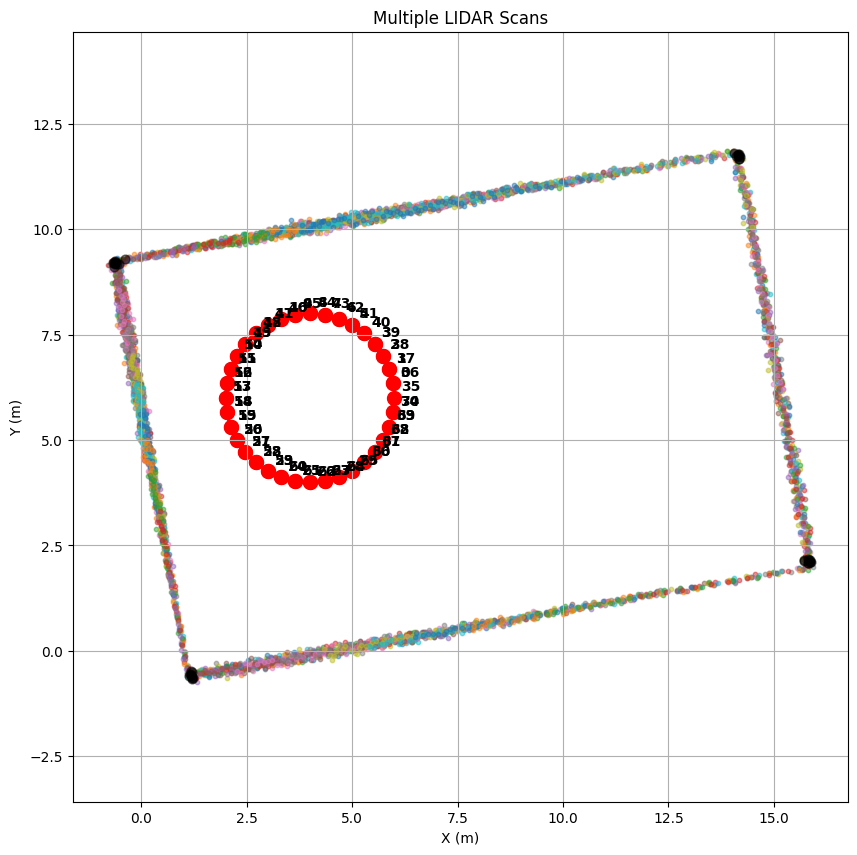

In [9]:
indices = np.arange(0, len(slam_data), 1).tolist()

plot_multiple_scans(slam_data, indices=indices)

# Draw the corner from the variable detected_corners
for corner in detected_corners:
	plt.scatter(corner[0], corner[1], c='k', s=40, alpha=0.5)



# Task2 - Position Estimation

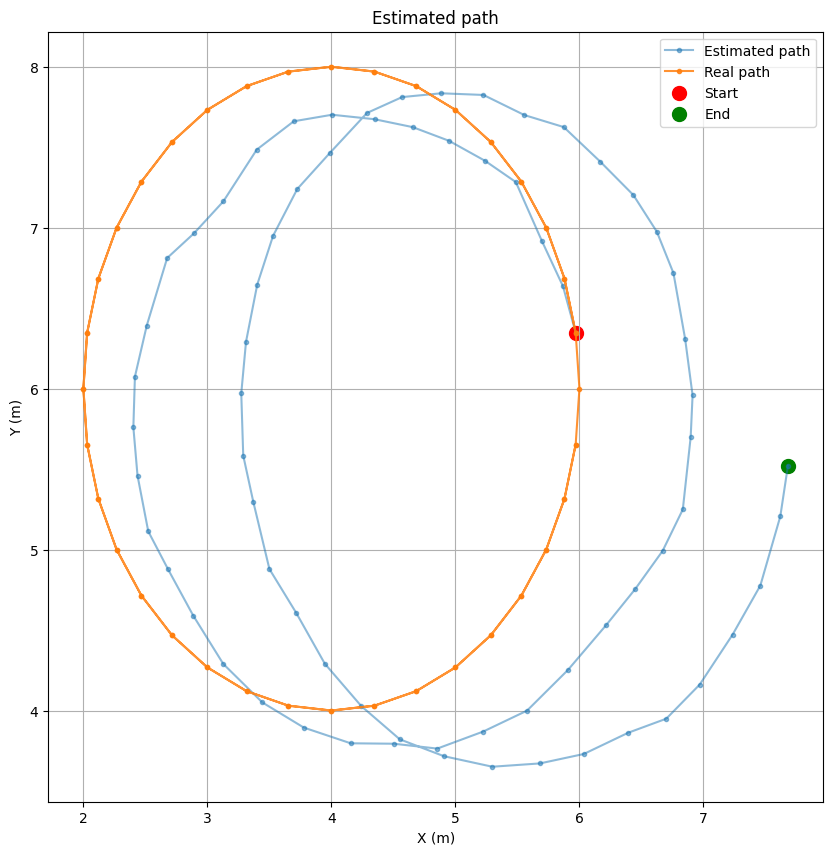

In [10]:
# Estimate next position based on the \deltax,

estimated_x = np.zeros(len(slam_data))
estimated_y = np.zeros(len(slam_data))
estimated_theta = np.zeros(len(slam_data))

estimated_x[0] = slam_data.iloc[0]['x']
estimated_y[0] = slam_data.iloc[0]['y']
estimated_theta[0] = slam_data.iloc[0]['theta']

delta_x = slam_data.iloc[:]['delta_x'].to_numpy()
delta_y = slam_data.iloc[:]['delta_y'].to_numpy()
delta_theta = slam_data.iloc[:]['delta_theta'].to_numpy()

for k in range(1, len(slam_data)):
	estimated_x[k] = estimated_x[k-1] + delta_x[k]
	estimated_y[k] = estimated_y[k-1] + delta_y[k]
	estimated_theta[k] = estimated_theta[k-1] + delta_theta[k]

# plot the results of the estimation
plt.figure(figsize=(10,10))
plt.plot(estimated_x, estimated_y, ".-", label='Estimated path', alpha=0.5)
# plot the real path
plt.plot(slam_data['x'], slam_data['y'], ".-", label='Real path', alpha=0.85)
plt.scatter(estimated_x[0], estimated_y[0], c='r', s=100, label='Start')
plt.scatter(estimated_x[-1], estimated_y[-1], c='g', s=100, label='End')
plt.legend()
plt.grid()
plt.title('Estimated path')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()


# Task3 - SLAM

## First let's try to transform the point clouds into the global frame but using the estimation of the robot position

Text(0.5, 1.0, 'Estimated Trajectory with LiDAR scans in global frame - no correction step')

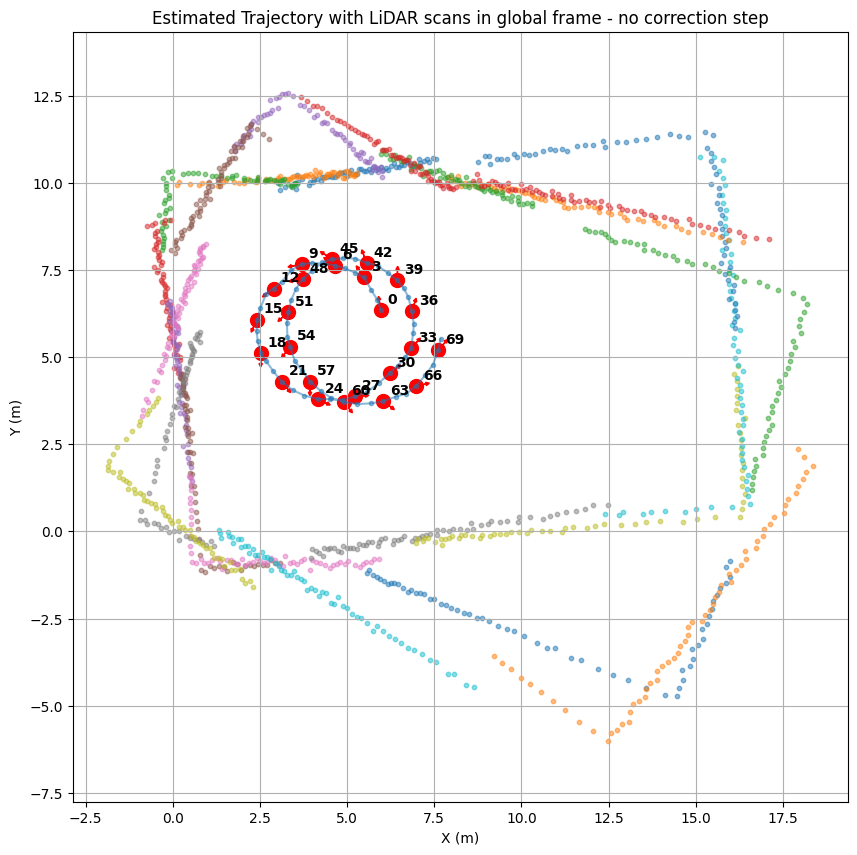

In [11]:
# Group the estimated values
estimation = np.zeros((len(slam_data), 3))
estimation[:,0] = estimated_x
estimation[:,1] = estimated_y
estimation[:,2] = estimated_theta

indices = np.arange(0, len(slam_data), 3).tolist()
plot_multiple_scans_with_estimation(slam_data, estimation, indices, legend=False)
plt.title("Estimated Trajectory with LiDAR scans in global frame - no correction step")

## Now let's just add the corner detection to this plot

In [12]:
def plot_multiple_scans_with_estimation_corner_detection(slam_data, estimation, indices, legend=False):
	"""Plot multiple LIDAR scans on the same plot."""
	plt.figure(figsize=(10, 8))

	# add the estimated trajectory
	plt.plot(estimation[:, 0], estimation[:, 1], ".-", label='Estimated path', alpha=0.5)

	for idx in indices:
		# Get robot pose
		robot_x = estimation[idx, 0]
		robot_y = estimation[idx, 1]
		robot_theta = estimation[idx, 2]

		# Get LIDAR measurements
		lidar_cols = [col for col in slam_data.columns if 'lidar_' in col]
		ranges = slam_data.iloc[idx][lidar_cols].values

		# Create angle array
		angles_deg = np.arange(-30, 31, 1)
		angles = np.deg2rad(angles_deg)

		# Convert to cartesian and transform to global frame
		local_x, local_y = polar_to_cartesian(ranges, angles)
		global_x, global_y = transform_to_global(local_x, local_y, robot_x, robot_y, robot_theta)

		# Plot points
		plt.scatter(global_x, global_y, s=10, alpha=0.5, label=f'Scan {idx}')

		# Plot robot position with index number
		plt.scatter(robot_x, robot_y, c='r', s=100)
		plt.annotate(str(idx), (robot_x, robot_y),
					xytext=(5, 5), textcoords='offset points',
					color='black', fontweight='bold')

		# Add orientation arrow
		orientation_length = 0.3
		plt.arrow(robot_x, robot_y,
					orientation_length * np.cos(robot_theta),
					orientation_length * np.sin(robot_theta),
					head_width=0.1, head_length=0.1, fc='r', ec='r')

		# Corner detection
		# filter ranges
		window_size = 5
		filtered_ranges = window_filter(ranges, window_size=window_size)
		flag, idx = corner_detector(angles_deg, filtered_ranges)

		if (flag):
			# get corner range
			corner_range = filtered_ranges[idx]
			# get corner angle
			corner_angle = angles_deg[idx]

			corner_refining_flag, corner_refined = corner_refining(angles_rad, filtered_ranges, idx, threshold=0.50)

			corner_x = corner_refined[0]
			corner_y = corner_refined[1]
			global_corner_x, global_corner_y = transform_to_global(corner_x, corner_y, robot_x, robot_y, robot_theta)
			plt.scatter(global_corner_x, global_corner_y, c='g', s=40)


	plt.axis('equal')
	plt.grid(True)
	if (legend):
		plt.legend()
	plt.title('Multiple LIDAR Scans')
	plt.xlabel('X (m)')
	plt.ylabel('Y (m)')
	#plt.show()

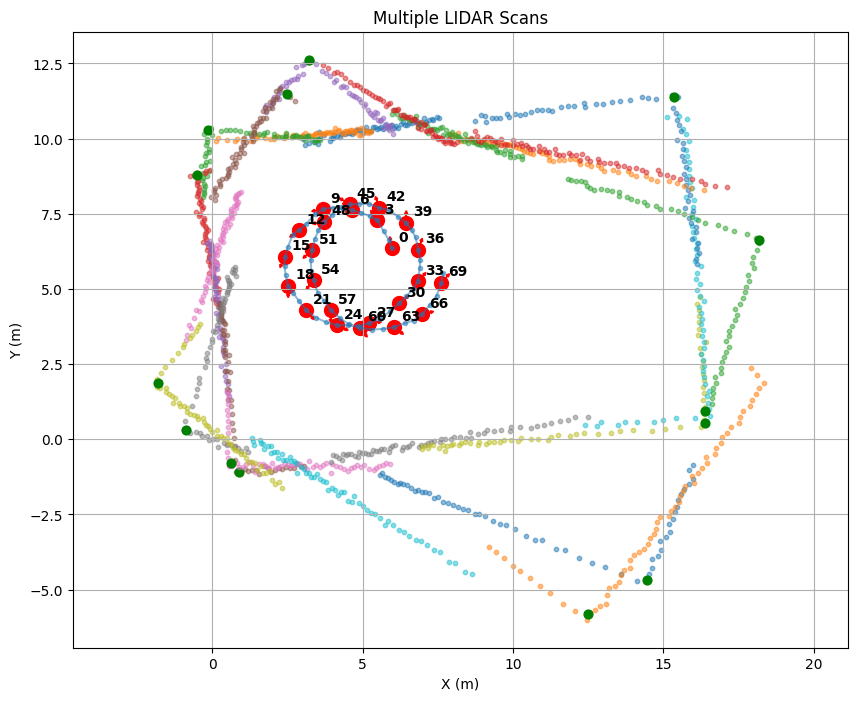

In [13]:
plot_multiple_scans_with_estimation_corner_detection(slam_data, estimation, indices, legend=False)

## SLAM

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from pathlib import Path
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression



def normalize_angle(angle):
    """
    Normalize an angle to the range [-pi, pi].
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

class EKFSLAMState:
	def __init__(self, initial_robot_state: np.ndarray):
		"""Initialize with just robot state [x, y, theta]"""
		self.robot_state_size = len(initial_robot_state)
		self.state = initial_robot_state.copy()
		# Initialize with some uncertainty in robot pose
		self.covariance = np.diag([0.0, 0.0, 0.0])  # x, y, theta uncertainties
		self.landmarks = {}
		self.total_state_size = self.robot_state_size
		self.Q = np.eye(3)
		#self.Q = np.eye(3) * 0.2**2 # State noise
		#self.Q[2, 2] = np.deg2rad(30**2)  # 45 degree standard deviation for thetar

		self.R = np.zeros((2,2))  # Landmark measurement noise
		self.R[0, 0] = 0.01**2
		self.R[1, 1] = np.deg2rad(0.1**2)  #  1 degree standard deviation for bearing

	def predict(self, delta: np.ndarray):
		"""
		Predict step using the motion model
		Args:
			delta: [dx, dy, dtheta] motion
		"""
		# Update robot state
		# X(k+1) = X(K) + U
		# U are the control signals dx, dy, dtheta
		self.state[:3,:] += delta
		self.state[2] = normalize_angle(self.state[2]) # Normalize theta between -pi and pi

		# Update Q matrix
		self.Q[0, 0] = (0.05 + np.abs(delta[0]).item())**2
		self.Q[1, 1] = (0.05 + np.abs(delta[1]).item())**2
		self.Q[2, 2] = (np.deg2rad(1) + np.abs(delta[2]).item())**2

		# Update covariance of robot pose --> consider that R is constant
		# P(k+1)=G*P(K)*G^T + Q
		# G is the jacobian of the state motion variables (Identity in this case)
		G = np.eye(3)
		self.covariance[0:3, 0:3] = G @ self.covariance[0:3, 0:3] @ G.T + self.Q

	def correct(self, landmark_id: int, measurement: np.ndarray):
		# observation with values measurement of feature landmark_id
		# measurement needs to be the range and the bearing of the landmark
		# measurement = [range, bearing]

		# Sanity check for row vector
		measurement = measurement.reshape(2,1)

		# get the landmark estimated position
		landmark_position = self.get_landmark_position(landmark_id)
		xl, yl = landmark_position
		landmark_state_idx = self.landmarks[landmark_id]['state_index']

		# Robot State
		xr = self.state[0,0]
		yr = self.state[1,0]
		thetar = self.state[2,0]

		# Measurement Estimation based on current state (robot pose and landmark position)
		d_estimated = np.sqrt((xl - xr)**2 + (yl - yr)**2)
		alpha_estimated = np.arctan2(yl - yr, xl - xr) - thetar
		z_est = np.array([d_estimated, alpha_estimated]).reshape(2,1)

		print("Correction phase")
		print("Estimated", z_est)
		print("Measurement", measurement)


		## calculate jacobian matrix of H(X)
		# df1/xr
		H = np.zeros((2, self.total_state_size))
		# calculate the jacobian matrix for xr, yr and thetar
		H[0, 0] = -(xl - xr) / d_estimated
		# df1/yr
		H[0, 1] = -(yl - yr) / d_estimated
		# df1/or
		H[0, 2] = 0

		# df2/xr
		H[1, 0] = (yl - yr) / d_estimated**2
		# df2/yr
		H[1, 1] = -(xl - xr) / d_estimated**2
		# df2/or
		H[1, 2] = -1

		# Now for the Landmark
		# df1/xl
		H[0, landmark_state_idx] = (xl - xr) / d_estimated
		# df1/yl
		H[0, landmark_state_idx+1] = (yl - yr) / d_estimated

		# df2/xl
		H[1, landmark_state_idx] = -(yl - yr) / d_estimated**2
		# df2/yr
		H[1, landmark_state_idx+1] = (xl - xr) / d_estimated**2

		# Kalman Gain
		K = self.covariance @ H.T @ np.linalg.inv(H @ self.covariance @ H.T + self.R)

		# Innovation
		self.state = self.state + K @ (measurement - z_est)

		# Covariance update
		self.covariance = (np.eye(self.total_state_size) - K @ H) @ self.covariance

		# update landmark position
		self.landmarks[landmark_id]['position'] = self.state[landmark_state_idx:landmark_state_idx+2].reshape(2,1)

		return

	def add_landmark(self, landmark_id: int, global_position: np.ndarray) -> None:
		"""Add new landmark observation"""
		if landmark_id in self.landmarks:
			return

		# Extend state vector
		new_state = np.zeros((self.total_state_size + 2, 1))  # +2 for x,y of landmark
		new_state[:self.total_state_size, :] = self.state
		new_state[self.total_state_size:, :] = global_position.reshape(2,1)

		# Extend covariance matrix
		new_covariance = np.zeros((len(new_state), len(new_state)))
		new_covariance[:self.total_state_size, :self.total_state_size] = self.covariance

		# High initial uncertainty for new landmark
		landmark_uncertainty = np.eye(2) * 1**2  # 1m standard deviation
		new_covariance[self.total_state_size:, self.total_state_size:] = landmark_uncertainty

		# Store landmark information
		self.landmarks[landmark_id] = {
			'id': landmark_id,
			'state_index': self.total_state_size,
			'position': global_position.copy()
		}

		self.state = new_state
		self.covariance = new_covariance
		self.total_state_size += 2

		print("Added new Landmark with id: ", landmark_id, " and position: ", global_position)

	def get_landmark_position(self, landmark_id: int) -> np.ndarray:
		"""Get position of a specific landmark"""
		if landmark_id not in self.landmarks:
			raise KeyError(f"Landmark {landmark_id} not found")
		idx = self.landmarks[landmark_id]['state_index']
		return self.state[idx:idx+2, 0]

def plot_slam_state(ax, slam_state: EKFSLAMState,
                   point_cloud_x=None, point_cloud_y=None,
                   step_number=None, detected_corner=None):
    """Plot the current SLAM state with uncertainty ellipses"""
    # Clear previous plots
    ax.clear()

    # Plot robot pose
    robot_pos = slam_state.state[:2,0]
    robot_theta = slam_state.state[2,0]

    # Plot robot position and orientation
    ax.scatter(robot_pos[0], robot_pos[1], c='r', s=100, label='Robot Position')

    if step_number is not None:
        ax.annotate(f'Step {step_number}', (robot_pos[0], robot_pos[1]),
                   xytext=(5, 5), textcoords='offset points',
                   color='black', fontweight='bold')

    # Plot robot orientation arrow
    arrow_length = 0.5
    dx = arrow_length * np.cos(robot_theta)
    dy = arrow_length * np.sin(robot_theta)
    ax.arrow(robot_pos[0], robot_pos[1], dx, dy,
             head_width=0.2, head_length=0.2, fc='r', ec='r')

    # Plot robot uncertainty ellipse
    robot_cov = slam_state.covariance[:2, :2]
    plot_covariance_ellipse(ax, robot_pos, robot_cov, color='r', alpha=0.3)

    # Plot landmarks and their uncertainties
    for landmark_id, landmark in slam_state.landmarks.items():
        pos = slam_state.state[landmark['state_index']:landmark['state_index']+2]
        cov = slam_state.covariance[landmark['state_index']:landmark['state_index']+2,
                                  landmark['state_index']:landmark['state_index']+2]

        # Plot landmark uncertainty
        plot_covariance_ellipse(ax, pos, cov, color='b', alpha=0.3)

        # Plot landmark position
        ax.scatter(pos[0], pos[1], c='b', marker='*', s=100)
        ax.annotate(f'L{landmark_id}', (pos[0], pos[1]),
                   xytext=(5, 5), textcoords='offset points')

    # Plot point cloud if provided
    if point_cloud_x is not None and point_cloud_y is not None:
        ax.plot(point_cloud_x, point_cloud_y, '.', color='gray', alpha=0.5,
                markersize=2, label='LiDAR points')

    # Plot detected corner if provided
    if detected_corner is not None:
        ax.scatter(detected_corner[0], detected_corner[1], c='g', marker='D', s=100,
                  label='Detected Corner')
        # Add detection circle
        circle = plt.Circle((detected_corner[0], detected_corner[1]),
                          0.5, color='g', fill=False, alpha=0.5)
        ax.add_patch(circle)

    ax.grid(True)
    ax.set_aspect('equal')
    ax.legend()

def plot_covariance_ellipse(ax, mean, covariance, confidence=0.95, color='b', alpha=0.3):
    """Plot uncertainty ellipse"""
    eigenvals, eigenvecs = np.linalg.eig(covariance)
    chi2_val = 5.991  # 95% confidence interval
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    width, height = 2 * np.sqrt(chi2_val * eigenvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                     color=color, alpha=alpha, fill=True)
    ax.add_patch(ellipse)

In [23]:
steps = range(1, len(slam_data), 1)

# Array that will have the model inputs
U = np.zeros((len(slam_data), 3))
U = slam_data.iloc[:][['delta_x', 'delta_y', 'delta_theta']].to_numpy()

# Initialize SLAM state with first pose
initial_pose = slam_data.iloc[0][['x', 'y', 'theta']].to_numpy().reshape(3,1)

ranges = slam_data.iloc[:][lidar_cols].to_numpy()

slam_state = EKFSLAMState(initial_pose)

# Create output directory for frames
output_dir = Path('slam_frames')
output_dir.mkdir(parents=True, exist_ok=True)

# Setup parameters
window_size = 5
feature_count = 0
distance_threshold_detection = 7


# Main loop
plt.figure(figsize=(15, 5))
for k in steps:
	fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

	print()
	print(f"Step {k}")

	# Predict step - update robot pose
	slam_state.predict(U[k].reshape(3,1))

	# Process LiDAR data
	filtered_ranges = window_filter(ranges[k], window_size=window_size)
	point_cloud_x_local, point_cloud_y_local = polar_to_cartesian(filtered_ranges, angles_rad)
	point_cloud_x_global, point_cloud_y_global = transform_to_global(
		point_cloud_x_local, point_cloud_y_local,
		slam_state.state[0,0], slam_state.state[1,0], slam_state.state[2,0]
	)

	# Corner detection
	detected_corner = None
	flag, idx = corner_detector(angles_deg, filtered_ranges)
	if flag:
		corner_refining_flag, corner_refined = corner_refining(
			angles_rad, filtered_ranges, idx, threshold=0.50
		)

		if corner_refining_flag:
			# Transform corner to global coordinates
			global_corner = transform_to_global(
				np.array([corner_refined[0]]), np.array([corner_refined[1]]),
				slam_state.state[0,0], slam_state.state[1,0], slam_state.state[2,0]
			)
			global_corner = np.array([global_corner[0][0], global_corner[1][0]])
			print(f"Detected corner at {global_corner}")
			detected_corner = global_corner

			# get the distance and angle of the detected corner in the robot frame
			# these are the model observations
			detected_corner_range = np.sqrt(corner_refined[0]**2 + corner_refined[1]**2)
			detected_corner_angle = normalize_angle(np.arctan2(corner_refined[1], corner_refined[0]))
			measurement = np.array([detected_corner_range, detected_corner_angle]).reshape(2,1)

			# Handle landmark management
			if feature_count == 0:
				# First landmark
				slam_state.add_landmark(feature_count, global_corner)
				feature_count += 1
			else:
				# Check if landmark is already observed
				new_landmark = True
				for landmark_id in slam_state.landmarks:
					landmark_pos = slam_state.get_landmark_position(landmark_id)
					print("landmark_registred: ", landmark_pos)
					print(np.sqrt(np.sum(np.power(global_corner - landmark_pos, 2))))
					dist = np.linalg.norm(global_corner - landmark_pos)
					print("dist:", dist)
					if dist < distance_threshold_detection:
						new_landmark = False
						# Perform correction of already observed feature
						slam_state.correct(landmark_id, measurement)
						break

				if new_landmark:
					slam_state.add_landmark(feature_count, global_corner)
					feature_count += 1

	# Plot current state
	plot_slam_state(ax1, slam_state,
					point_cloud_x_global, point_cloud_y_global,
					k, detected_corner)
	ax1.set_title(f'SLAM State - Step {k}')

	# Save frame
	plt.savefig(output_dir / f'frame_{k:04d}.png', dpi=200)
	plt.close()


Step 1

Step 2

Step 3

Step 4
Detected corner at [-0.05978684 10.43701391]
Added new Landmark with id:  0  and position:  [-0.05978684 10.43701391]

Step 5
Detected corner at [-0.06312471 10.48852011]
landmark_registred:  [-0.05978684 10.43701391]
0.05161423938112001
dist: 0.05161423938112001
Correction phase
Estimated [[5.78606783]
 [0.27663156]]
Measurement [[5.81490693]
 [0.26925183]]

Step 6
Detected corner at [-0.14178775 10.26633791]
landmark_registred:  [-0.07381006 10.45413319]
0.19971989084110287
dist: 0.19971989084110287
Correction phase
Estimated [[5.51985617]
 [0.06817109]]
Measurement [[5.48513516]
 [0.1039167 ]]

Step 7
Detected corner at [-0.15591385 10.27363994]
landmark_registred:  [-0.07950467 10.44501518]
0.18763750813578747
dist: 0.18763750813578747
Correction phase
Estimated [[ 5.19649181]
 [-0.09937865]]
Measurement [[ 5.17320498]
 [-0.06346683]]

Step 8
Detected corner at [-0.27010187  9.92817592]
landmark_registred:  [-0.08662539 10.43369036]
0.537781059067381

<Figure size 1500x500 with 0 Axes>

In [19]:
import numpy as np

# Extract landmarks' positions
landmarks = slam_state.state[3:].reshape(-1, 2)  # Each landmark has (x, y)

print("Features Pos after Slam:")
print(landmarks)

# Compute pairwise distances
num_landmarks = len(landmarks)
distances = np.zeros((num_landmarks, num_landmarks))

for i in range(num_landmarks):
    for j in range(num_landmarks):
        if i != j:
            distances[i, j] = np.linalg.norm(landmarks[i] - landmarks[j])

# Print distances
print("\nPairwise Distances Between Landmarks:")
for i in range(num_landmarks):
    for j in range(i + 1, num_landmarks):
        print(f"Distance between Landmark {i} and {j}: {distances[i, j]:.4f}")

Features Pos after Slam:
[[ 0.26850836 10.80098207]
 [-3.66250538  0.25463681]
 [11.67372322 -6.45133673]
 [16.75038917  3.12255013]]

Pairwise Distances Between Landmarks:
Distance between Landmark 0 and 1: 11.2551
Distance between Landmark 0 and 2: 20.6814
Distance between Landmark 0 and 3: 18.1827
Distance between Landmark 1 and 2: 16.7383
Distance between Landmark 1 and 3: 20.6134
Distance between Landmark 2 and 3: 10.8366


In [20]:
import imageio
import glob
import re

def natural_sort_key(s):
    """
    Sort strings that contain numbers in natural order
    For example: ["img1.png", "img2.png", "img10.png"] instead of ["img1.png", "img10.png", "img2.png"]
    """
    s = str(s)
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

# Create video using your method
images = list(output_dir.glob('*.png'))
images.sort(key=natural_sort_key)
print(f"Found {len(images)} images")

frames = [imageio.v2.imread(str(img)) for img in images]

video_dir = output_dir.parent / 'videos'
video_dir.mkdir(parents=True, exist_ok=True)

video_path = video_dir / 'slam_visualization.mp4'
imageio.mimwrite(str(video_path), frames, fps=2, macro_block_size=1)
print(f"Video created successfully at {video_path}!")

Found 70 images
Video created successfully at videos/slam_visualization.mp4!


In [18]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/videos/slam_visualization.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1500 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)